Show and tell of ONNX->TRT conversion
1. Test docker environment 
1. ~~Images in git~~
1. ~~Model in git~~
1. ~~Load ONNX Model~~
1. ~~Display inference~~
1. Convert to TRT -> Save & display results file
1. Display inference

In [1]:
import sys, os
from glob import glob
import tqdm
import onnxruntime as ort
import numpy as np
import cv2
import IPython
# locate imports from either mllib directory or target directory
sys.path.append(os.path.abspath(''))
sys.path.append(os.path.abspath('..'))
from utils.jsonutil import ReadDictJson
from datasets.cocostore import resize_crop_or_pad
from utils.metrics import MergeIman, DatasetResults

In [2]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [3]:
images = glob('test/*.jpg')

In [4]:
class_dictionary_name= 'test/coco.json'
class_dictionary = ReadDictJson(class_dictionary_name)
class_dictionary

{'background': 0,
 'ignore': 255,
 'classes': 21,
 'objects': [{'id': 0,
   'name': 'unlabeled',
   'trainId': 0,
   'category': 'void',
   'display': False,
   'color': [0, 0, 0]},
  {'id': 1,
   'name': 'person',
   'trainId': 1,
   'category': 'person',
   'display': True,
   'color': [0, 255, 0]},
  {'id': 2,
   'name': 'bicycle',
   'trainId': 2,
   'category': 'vehicle',
   'display': True,
   'color': [255, 0, 0]},
  {'id': 3,
   'name': 'car',
   'trainId': 2,
   'category': 'vehicle',
   'display': True,
   'color': [255, 0, 0]},
  {'id': 4,
   'name': 'motorcycle',
   'trainId': 2,
   'category': 'vehicle',
   'display': True,
   'color': [255, 0, 0]},
  {'id': 5,
   'name': 'airplane',
   'trainId': 2,
   'category': 'vehicle',
   'display': True,
   'color': [255, 0, 0]},
  {'id': 6,
   'name': 'bus',
   'trainId': 2,
   'category': 'vehicle',
   'display': True,
   'color': [255, 0, 0]},
  {'id': 7,
   'name': 'train',
   'trainId': 2,
   'category': 'vehicle',
   'display

In [6]:
modelname='test/segment_nas_512x442_20211119_00.onnx'
onnxsess = ort.InferenceSession(modelname)
input_name = onnxsess.get_inputs()[0].name
input_name

/home/blarson/.local/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:350: UserWarning: Deprecation warning. This ORT build has ['CUDAExecutionProvider', 'CPUExecutionProvider'] enabled. The next release (ORT 1.10) will require explicitly setting the providers parameter (as opposed to the current behavior of providers getting set/registered by default based on the build flags) when instantiating InferenceSession.For example, onnxruntime.InferenceSession(..., providers=["CUDAExecutionProvider"], ...)
  warnings.warn("Deprecation warning. This ORT build has {} enabled. ".format(available_providers) +


'image'

In [7]:
dsResults = DatasetResults(class_dictionary)

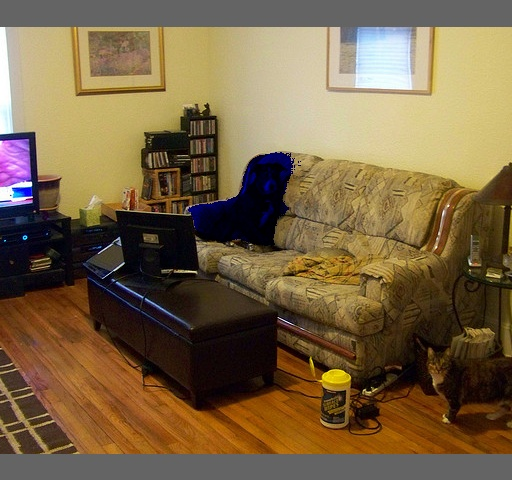

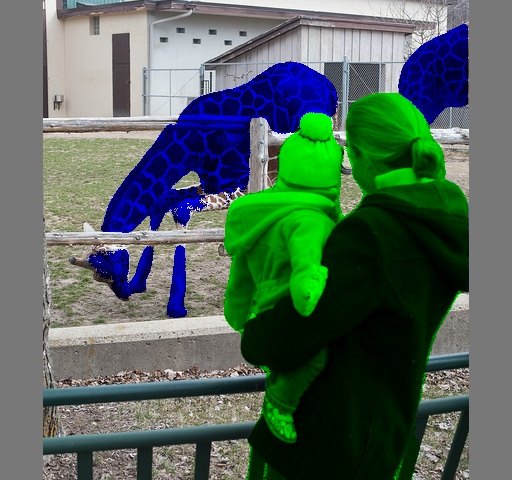

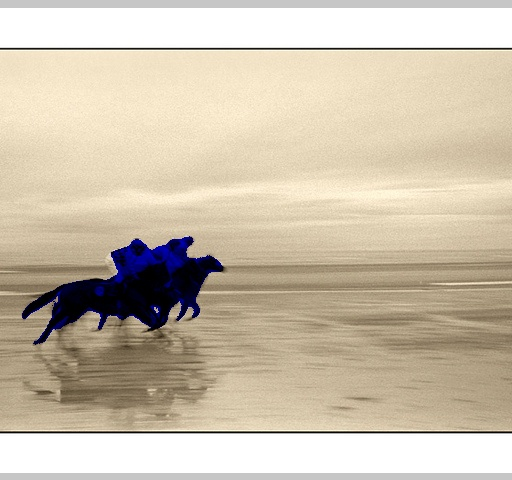

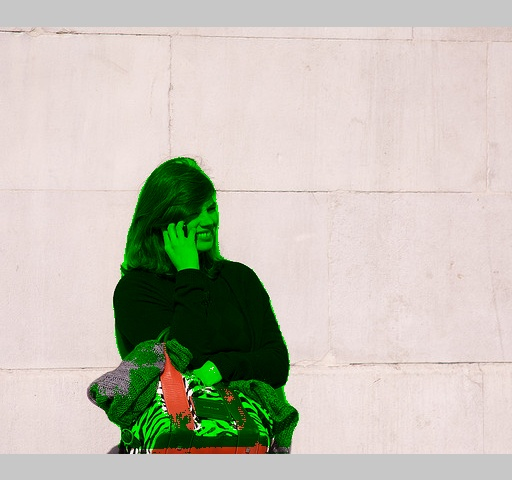

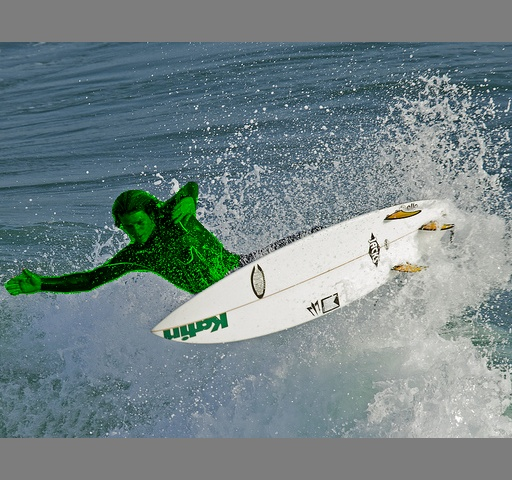

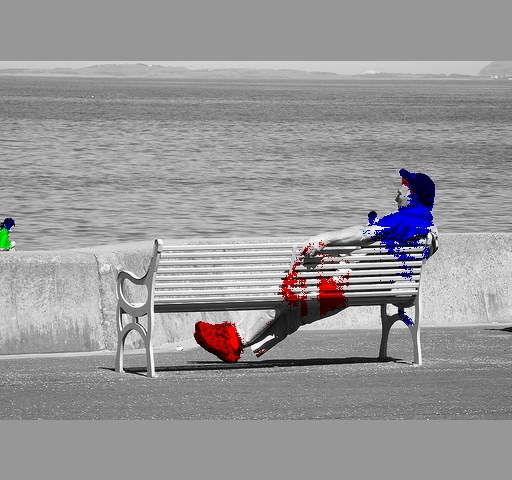

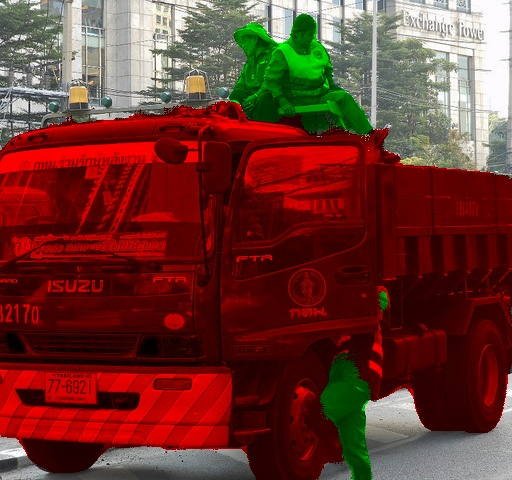

In [9]:
for imagename in images:
    image = cv2.imread(imagename)
    image, imgMean, imgStd = resize_crop_or_pad(image, 480,512)
    imageBCHW = np.expand_dims(image.transpose(2, 0, 1),0)
    predonnx = onnxsess.run(None, {input_name: imageBCHW})
    segmentation = np.argmax(predonnx[0], axis=1).astype('uint8')[0]

    iman = MergeIman(image, segmentation, dsResults.lut,imgMean, imgStd)
    imshow(iman)